In [1]:
import pandas as pd
import janitor
import warnings
import numpy as np

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")
from utilities import save_mpl_fig
from IPython.display import display

In [2]:
df = (
    pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
    .rename_column("visit_duration", "duration")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        malicious_hr=lambda df_: df_["malicious_bool"] * df_["duration_hr"],
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    )
    # ==================================================
    # Merge to ind demo (n = 1200)
    .merge(
        (
            pd.read_csv("../data/profile.csv").assign(
                # https://github.com/themains/bad_domains/blob/main/data/codebook.pdf
                gender_lab=lambda df_: df_["gender"].replace({1: "Male", 2: "Female"}),
                race_lab=lambda df_: df_["race"].replace(
                    {
                        1: "White",
                        2: "Black",
                        3: "Hispanic",
                        4: "Asian",
                        5: "Other",
                        6: "Other",
                        7: "Other",
                        8: "Other",
                    }
                ),
                educ_lab=lambda df_: df_["educ"].replace(
                    {
                        1: "HS or Below",
                        2: "HS or Below",
                        3: "Some college",
                        4: "Some college",
                        5: "College",
                        6: "Postgrad",
                    }
                ),
                agegroup_lab=lambda df_: pd.cut(
                    df_["birthyr"],
                    # early baby boomers
                    # late baby boomers/ early genX
                    # genX, early millenials
                    # millenials
                    # genZ
                    bins=[1930, 1957, 1972, 1987, 1997, 2003],
                    labels=["65+", "50--65", "35--50", "25--35", "<25"],
                ),
            )
        ),
        how="left",
        on="caseid",
        validate="m:1",
    )
    # ==================================================
    # ToD
    .dropna(subset=["visit_time_local"])
    .assign(
        visit_time_local=lambda df_: pd.to_datetime(
            df_["visit_time_local"], format="ISO8601"
        ),
        hour_of_day=lambda df_: pd.to_datetime(df_["visit_time_local"]).dt.hour
        + pd.to_datetime(df_["visit_time_local"]).dt.minute / 60
        + pd.to_datetime(df_["visit_time_local"]).dt.second / 3600,
        hour_of_day_shifted6=lambda df_: (df_["hour_of_day"] - 6) % 24,
    )
)
display(df.head())
df.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab,hour_of_day,hour_of_day_shifted6
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,0.033333,0.000556,google.com,70.0,0.0,...,7,2,45,3,Male,White,Some college,50--65,23.876944,17.876944
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,7.616667,0.126944,coupons.com,68.0,0.0,...,7,2,45,3,Male,White,Some college,50--65,1.126389,19.126389
2,205323077,google.com,Business,2022-06-01 01:15:12,55,0.916667,0.015278,google.com,70.0,0.0,...,7,2,45,3,Male,White,Some college,50--65,1.253333,19.253333
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,37.083333,0.618056,coupons.com,68.0,0.0,...,7,2,45,3,Male,White,Some college,50--65,1.268611,19.268611
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,0.166667,0.002778,google.com,70.0,0.0,...,7,2,45,3,Male,White,Some college,50--65,4.636111,22.636111


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297382 entries, 0 to 6297381
Data columns (total 37 columns):
 #   Column                Dtype         
---  ------                -----         
 0   caseid                int64         
 1   private_domain        object        
 2   category              object        
 3   visit_time_local      datetime64[ns]
 4   duration              int64         
 5   duration_min          float64       
 6   duration_hr           float64       
 7   filename              object        
 8   harmless              float64       
 9   malicious             float64       
 10  suspicious            float64       
 11  undetected            float64       
 12  timeout               float64       
 13  forcepoint            object        
 14  sophos                object        
 15  bitdefender           object        
 16  comodo                object        
 17  alphamnt              object        
 18  malicious_bool        bool          
 19  

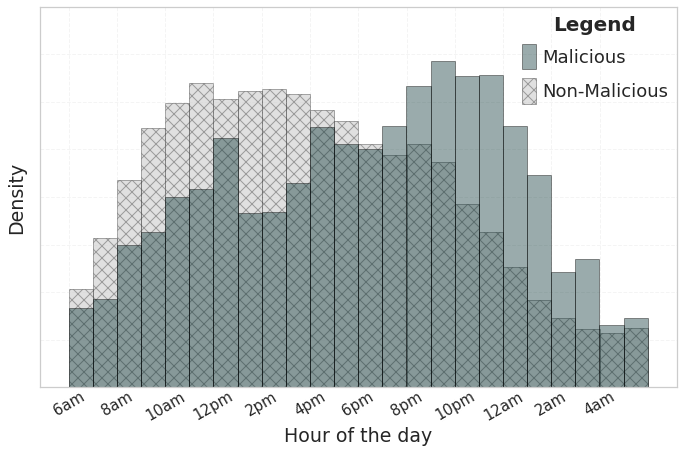

In [4]:
# plot
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

ax.hist(
    df.query("malicious_bool == True")["hour_of_day_shifted6"],
    bins=24,
    alpha=0.4,
    label="Malicious",
    color="#032f30",
    edgecolor="black",
    density=True,
    zorder=1,
)

ax.hist(
    df.query("malicious_bool == False")["hour_of_day_shifted6"],
    bins=24,
    alpha=0.4,
    label="Non-Malicious",
    color=".7",
    edgecolor=".2",
    hatch="xx",
    density=True,
    zorder=0,
)
ax.set_yticklabels([])
ax.set_ylabel("Density", fontsize=19)
ax.set_xlabel("Hour of the day", fontsize=19)
xticks = np.arange(0, 24, 2)
xtick_labels = [
    f"{(6 + t) % 12 or 12}{'am' if (6 + t) % 24 < 12 else 'pm'}" for t in xticks
]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=30)
# Adjust the padding between tick labels and axis
ax.xaxis.set_tick_params(pad=-5)


ax.set_ylim(0, 0.08)
plt.legend(
    title="Legend",
    loc="upper right",
    fontsize=18,
    title_fontproperties={"weight": "bold", "size": 20},
    frameon=False,
    handlelength=0.8,
    handleheight=1.8,
    handletextpad=0.3,
    labelspacing=0.5,
    borderpad=0.0,
)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/hist-time-of-day-mal-nonmal")